In [11]:
import sys
import numpy as np
import xarray as xr
#from glob import glob
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
import matplotlib.pyplot as plt
#sys.path.append('./subroutines/')
#from read_routines import read_usv, get_filelist_amsr2_l1r,get_orbital_data_amsr2

#for search capabilites import podaacpy
import podaac.podaac as podaac

# then create an instance of the Podaac class
p = podaac.Podaac()
#to obtain rich information from PO.DAAC Drive, import and creat an instance of Drive
from podaac import drive as drive
#note autherntication credentials are provided in the 'podaac.ini' file
#C:\\Users\\gentemann\\Miniconda3\\envs\\satenv\\lib\\site-packages\\podaac\\tests\\podaac.ini
d = drive.Drive('.\podaac.ini', None, None)

In [22]:
#right now the podaacpy api seems to have a problem and only returns 7 files.  
#I contacted the developer and asked about this.
#hopefully it is a quick fix for him
#use podaac drive to find we provide a convenience function which enables easy access to all Drive urls
gresult = p.granule_search(dataset_id='PODAAC-GHVRS-2PN16',start_time='2013-01-06T00:00:00Z',end_time='2013-12-31T23:59:59Z')
urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)
#podaac drive requires credentials and this isn't compatible with how xarray reads in data, so let's switch to opendap dir by changing file path
#if podaac drive is mapped to your computer you could also just change this to your filepath
#print(urls)
urls_sst = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls]
print(urls_sst)

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/VIIRS_NPP/JPL/v2016.0/2013/006/20130106000000-JPL-L2P_GHRSST-SSTskin-VIIRS_NPP-N-v02.0-fv01.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/VIIRS_NPP/JPL/v2016.0/2013/006/20130106000000-JPL-L2P_GHRSST-SSTskin-VIIRS_NPP-D-v02.0-fv01.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/VIIRS_NPP/JPL/v2016.0/2013/006/20130106000600-JPL-L2P_GHRSST-SSTskin-VIIRS_NPP-D-v02.0-fv01.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/VIIRS_NPP/JPL/v2016.0/2013/006/20130106001200-JPL-L2P_GHRSST-SSTskin-VIIRS_NPP-D-v02.0-fv01.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/VIIRS_NPP/JPL/v2016.0/2013/006/20130106001800-JPL-L2P_GHRSST-SSTskin-VIIRS_NPP-D-v02.0-fv01.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/VIIRS_NPP/JPL/v2016.0/2013/006/20130106002400-JPL-L2P_GHRSST

In [36]:
area_def = load_area('areas.cfg', 'pc_world')
rlon=np.arange(-180,180,.1)
rlat=np.arange(90,-90,-.1)
for file in urls_sst:
    ds = xr.open_dataset(file)
    ds.close()
    if ds.attrs['northernmost_latitude']<25:
        continue
    if ds.attrs['southernmost_latitude']>45:
        continue
    if ds.attrs['easternmost_longitude']>-50:
        continue
    if ds.attrs['westernmost_longitude']<-80:
        continue
    x = ds.lon.data
    y = ds.lat.data
    z = ds.sea_surface_temperature.data
    lons,lats,data = x,y,z 
    swath_def = SwathDefinition(lons, lats)
    result = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
    #save_quicklook('C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/sss.png', area_def, result, num_meridians=0, num_parallels=0, label='Salinity (psu)')
    #now plot on basemap
    bmap = area_def2basemap(area_def)
    bmng = bmap.bluemarble()
    col = bmap.imshow(result, origin='upper',vmin=8,vmax=32)

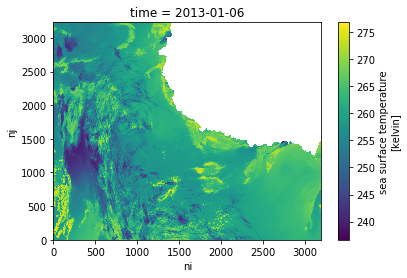

In [24]:
ds.sea_surface_temperature.plot()

In [20]:
ds.quality_level

<xarray.DataArray 'quality_level' (time: 1, nj: 3232, ni: 3200)>
[10342400 values with dtype=float32]
Coordinates:
    lat      (nj, ni) float32 16.458584 16.457119 ... -8.44895 -8.450876
    lon      (nj, ni) float32 -103.20303 -103.18749 ... -80.090904 -80.07602
  * time     (time) datetime64[ns] 2012-01-06T07:30:01
Dimensions without coordinates: nj, ni
Attributes:
    long_name:      quality level of SST pixel
    valid_min:      0
    valid_max:      5
    comment:        thermal IR SST quality value; signed byte array: WARNING ...
    flag_values:    [0 1 2 3 4 5]
    flag_meanings:  no_data bad_data worst_quality low_quality acceptable_qua...

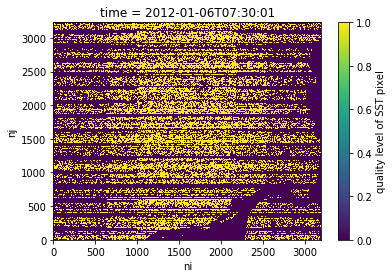

In [21]:
ds.quality_level.plot()

In [38]:
dirs = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/VIIRS_NPP/JPL/v2016.0/2013/006/'
ds = xr.open_mfdataset(dirs)
ds

ValueError: cannot do wild-card matching for paths that are remote URLs: 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/VIIRS_NPP/JPL/v2016.0/2013/006/'. Instead, supply paths as an explicit list of strings.

In [34]:
ds

<xarray.Dataset>
Dimensions:                  (ni: 3200, nj: 3248, time: 1)
Coordinates:
    lat                      (nj, ni) float32 -30.85334 ... -14.993262
    lon                      (nj, ni) float32 -143.08453 ... -178.76872
  * time                     (time) datetime64[ns] 2013-01-06T00:24:00
Dimensions without coordinates: ni, nj
Data variables:
    sea_surface_temperature  (time, nj, ni) float32 nan nan nan ... nan nan nan
    sst_dtime                (time, nj, ni) timedelta64[ns] ...
    quality_level            (time, nj, ni) float32 ...
    sses_bias                (time, nj, ni) float32 ...
    sses_standard_deviation  (time, nj, ni) float32 ...
    l2p_flags                (time, nj, ni) int16 ...
    wind_speed               (time, nj, ni) float32 ...
    dt_analysis              (time, nj, ni) float32 ...
Attributes:
    Conventions:                CF-1.6, ACDD-1.1
    title:                      VIIRS L2P Sea Surface Skin Temperature
    summary:                    